# 0. Library

In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import warnings
import pickle
import os

# --- Sklearn ---
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, auc,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, brier_score_loss, log_loss, classification_report)
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

# --- TabNet & PyTorch ---
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

# 1. Utility functions + Configurations

## 1.1 Utility functions

In [2]:
# --- Helper Functions (can be imported from a utils file or redefined) ---
def calculate_ks(y_true, y_prob):
    """Calculates the Kolmogorov-Smirnov (KS) statistic."""
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values(by='y_prob', ascending=False)
    # Ensure y_true sums are not zero before division
    sum_true = df['y_true'].sum()
    sum_false = len(df) - sum_true
    if sum_true == 0 or sum_false == 0:
        return 0.0 # KS is 0 if one class is missing
    df['cumulative_true'] = df['y_true'].cumsum() / sum_true
    df['cumulative_false'] = (1 - df['y_true']).cumsum() / sum_false
    ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
    return ks

def find_optimal_threshold_j_statistic(y_true, y_prob_oof):
    """Finds the optimal threshold maximizing Youden's J statistic (Sensitivity + Specificity - 1)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob_oof)
     # Handle cases where thresholds might not be strictly decreasing
    valid_indices = np.where(np.isfinite(thresholds))[0]
    if len(valid_indices) == 0:
        print("Warning: No valid thresholds found for J-statistic calculation.")
        return 0.5 # Default fallback
    fpr, tpr, thresholds = fpr[valid_indices], tpr[valid_indices], thresholds[valid_indices]

    if len(thresholds) == 0:
         print("Warning: Threshold array is empty after filtering.")
         return 0.5

    j_statistic = tpr - fpr
    optimal_idx = np.argmax(j_statistic)
    optimal_threshold = thresholds[optimal_idx]
    # Ensure threshold is within [0, 1] bounds if necessary due to floating point issues
    optimal_threshold = max(0.0, min(1.0, optimal_threshold))
    print(f"Optimal threshold based on Youden's J-Statistic (OOF): {optimal_threshold:.4f}")
    return optimal_threshold

def evaluate_model(y_true, y_pred_proba, y_pred_binary, model_name="Model"):
    """Calculates and prints standard classification metrics."""
    # Add epsilon to probabilities for log_loss if necessary
    eps = 1e-15
    y_pred_proba = np.clip(y_pred_proba, eps, 1 - eps)

    auc_roc = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc_roc - 1
    ks = calculate_ks(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    brier = brier_score_loss(y_true, y_pred_proba)
    logloss = log_loss(y_true, y_pred_proba)
    cm = confusion_matrix(y_true, y_pred_binary)

    print(f"\n--- Evaluation Metrics for {model_name} ---")
    print(f"AUC ROC:        {auc_roc:.4f}")
    print(f"Gini Coefficient: {gini:.4f}")
    print(f"KS Statistic:   {ks:.4f}")
    print(f"Accuracy:       {accuracy:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall (TPR):   {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"Brier Score:    {brier:.4f}")
    print(f"Log Loss:       {logloss:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    results = {
        'Model': model_name,
        'AUC': auc_roc, 'Gini': gini, 'KS': ks, 'Accuracy': accuracy,
        'Precision': precision, 'Recall': recall, 'F1': f1,
        'Brier': brier, 'LogLoss': logloss
    }
    return results

def plot_roc_curve(y_true, y_prob, model_name):
    """Plots the ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_roc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_roc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.grid(True)
    # Save the plot
    plot_filename = f"roc_curve_{model_name.replace(' ', '_')}.png"
    plt.savefig(plot_filename)
    print(f"ROC curve saved to {plot_filename}")
    plt.show()

## 1.2 Configurations

In [3]:
# --- Configuration ---
DATA_PATH = '../data/processed/'
MODEL_OUTPUT_PATH = './tabnet_outputs/'
os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)
SEED = 42
N_SPLITS = 10
TARGET = 'TARGET'
ID_COL = 'SK_ID_CURR'

# --- Check for GPU ---
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device_name}")

Using device: cuda


# 2. Load Data and Preprocess

In [4]:
# --- Load Data ---
print("Loading preprocessed data...")
try:
    train_df = pd.read_csv(DATA_PATH + 'train.csv')
    test_df = pd.read_csv(DATA_PATH + 'test.csv')
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure 'train_final.csv' and 'test_final.csv' are in {DATA_PATH}")
    exit()

# --- Prepare Data ---
y_train = train_df[TARGET].values # Use .values for numpy arrays
y_test = test_df[TARGET].values

# Drop Target and potentially ID
if ID_COL in train_df.columns:
    X_train = train_df.drop(columns=[TARGET, ID_COL])
    X_test = test_df.drop(columns=[TARGET, ID_COL])
else:
    X_train = train_df.drop(columns=[TARGET])
    X_test = test_df.drop(columns=[TARGET])

# Align columns just in case
common_cols = list(X_train.columns.intersection(X_test.columns))
X_train = X_train[common_cols]
X_test = X_test[common_cols]
feature_names = X_train.columns.tolist()

Loading preprocessed data...
Data loaded successfully.


In [5]:
# --- LIMITATION: Treat all features as numerical ---
# Ideally, identify original categorical features and pass their indices to TabNet.
# Since we are using pre-encoded data, we treat all as numerical.
print("WARNING: Treating all features as numerical for TabNet due to pre-encoded input data.")
categorical_indices = [] # No categorical indices provided
categorical_dims = [] # No specific dimensions needed if indices are empty

# Handle infinite values and NaNs
# Replace inf with NaN, then fill NaN with median of each column
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(X_train.median())
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X_train.median()) # Use train median for test set

# Standardize the data
# Note: TabNet can handle raw data, but standardization may help in some cases.
# You can comment this out if you prefer to use raw data.
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Convert to numpy arrays of type float32 for PyTorch
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)

print(f"Prepared X_train shape: {X_train_np.shape}")
print(f"Prepared X_test shape: {X_test_np.shape}")

Prepared X_train shape: (246005, 112)
Prepared X_test shape: (61502, 112)


# 3. Train and Evaluate

## 3.1 Train Baseline Model

In [6]:
# Calculate class weights inversely proportional to class frequencies
class_counts = np.bincount(y_train)
total_samples = len(y_train)
# More aggressive weighting for minority class
class_weights = torch.tensor([1.0, (class_counts[0]/class_counts[1]) * 1.0], dtype=torch.float32)
if device_name == 'cuda':
    class_weights = class_weights.cuda()

print(f"Using class weights: {class_weights.cpu().numpy()} to emphasize minority class")

# Create weighted loss function
weighted_loss = torch.nn.CrossEntropyLoss(weight=class_weights)

Using class weights: [ 1.       11.386959] to emphasize minority class



Training Baseline TabNet highest Model without CV...


c:\Users\ORLab\main_source\CreditRiskProject\venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


TabNet highest model initialized on cuda
Fitting baseline TabNet highest model...
epoch 0  | loss: 0.86709 | validation_logloss: 3.40103 | validation_accuracy: 0.65336 | validation_auc: 0.50844 | validation_balanced_accuracy: 0.50372 |  0:00:02s
epoch 1  | loss: 0.88177 | validation_logloss: 1.05519 | validation_accuracy: 0.84836 | validation_auc: 0.51385 | validation_balanced_accuracy: 0.49932 |  0:00:05s
epoch 2  | loss: 0.87274 | validation_logloss: 1.28633 | validation_accuracy: 0.55926 | validation_auc: 0.50056 | validation_balanced_accuracy: 0.50605 |  0:00:08s
epoch 3  | loss: 0.76773 | validation_logloss: 1.34571 | validation_accuracy: 0.32455 | validation_auc: 0.52113 | validation_balanced_accuracy: 0.5171  |  0:00:10s
epoch 4  | loss: 0.723   | validation_logloss: 0.63671 | validation_accuracy: 0.76173 | validation_auc: 0.55051 | validation_balanced_accuracy: 0.49906 |  0:00:13s
epoch 5  | loss: 0.6922  | validation_logloss: 0.48531 | validation_accuracy: 0.90142 | validation

c:\Users\ORLab\main_source\CreditRiskProject\venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Baseline model training completed in 283.50 seconds.

--- Baseline TabNet Model Evaluation ---

--- Evaluation Metrics for TabNet_highest (Baseline) ---
AUC ROC:        0.7538
Gini Coefficient: 0.5077
KS Statistic:   0.3796
Accuracy:       0.7065
Precision:      0.1678
Recall (TPR):   0.6653
F1-Score:       0.2679
Brier Score:    0.1878
Log Loss:       0.5557

Confusion Matrix:
[[40151 16386]
 [ 1662  3303]]
ROC curve saved to roc_curve_TabNet_highest_(Baseline).png


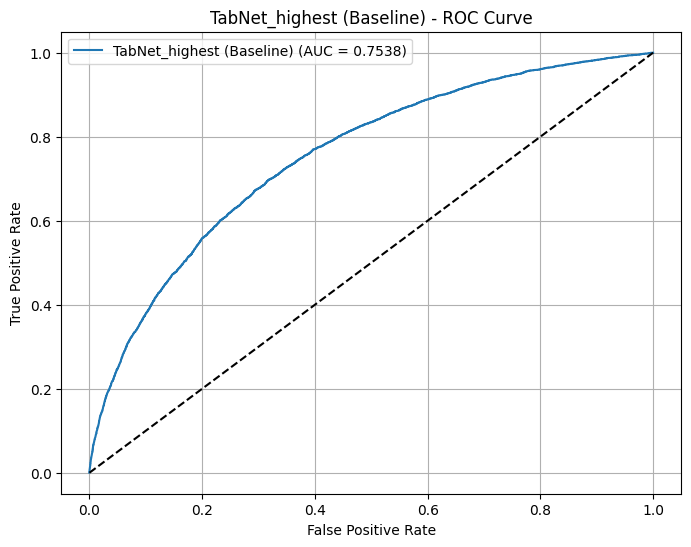

Successfully saved model at ./tabnet_outputs/tabnet_highest_baseline_model.zip
Baseline model saved to ./tabnet_outputs/tabnet_highest_baseline_model.zip
Baseline results saved to ./tabnet_outputs/tabnet_highest_baseline_results.csv
Baseline feature importance saved to ./tabnet_outputs/tabnet_highest_baseline_feature_importance.csv


In [ ]:
# --- Initialize and Train a Baseline TabNet Model ---
print("\nTraining Baseline TabNet highest Model without CV...")

TABNET_PARAMS = dict(
    n_d=64, n_a=64, n_steps=2, n_independent=6, n_shared=6,
    mask_type='sparsemax', gamma=1.7, lambda_sparse=0.01,
    optimizer_fn=torch.optim.AdamW, optimizer_params=dict(lr=0.001),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(
        mode="max", patience=20, min_lr=1e-6, factor=0.5),
    seed=SEED, verbose=1, clip_value=1.0, device_name=device_name,
)

MAX_EPOCHS = 3000
PATIENCE = 20
BATCH_SIZE = 8192*2
VIRTUAL_BATCH_SIZE = 2048*2

# Split off a small portion of the training data for validation (early stopping purposes)
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    X_train_np, y_train, test_size=0.20, random_state=SEED, stratify=y_train
)

tabnet_baseline = TabNetClassifier(**TABNET_PARAMS)
print(f"TabNet highest model initialized on {device_name}")
print("Fitting baseline TabNet highest model...")
start_time = time.time()

    
tabnet_baseline.fit(
    X_train=X_train_base, y_train=y_train_base,
    eval_set=[(X_val_base, y_val_base)],
    eval_name=['validation'],
    eval_metric=['logloss', 'accuracy', 'auc', 'balanced_accuracy'],
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    batch_size=BATCH_SIZE,
    virtual_batch_size=VIRTUAL_BATCH_SIZE,
    drop_last=False,
    loss_fn=weighted_loss,
    num_workers=0,
)

end_time = time.time()
print(f"Baseline model training completed in {(end_time - start_time):.2f} seconds.")

# Make predictions
baseline_preds = tabnet_baseline.predict_proba(X_test_np)[:, 1]
baseline_binary_preds = (baseline_preds > 0.5).astype(int)

# Evaluate the baseline model
print("\n--- Baseline TabNet Model Evaluation ---")
baseline_results = evaluate_model(
    y_test, baseline_preds, baseline_binary_preds, model_name="TabNet_highest (Baseline)"
)

# Plot ROC curve
plot_roc_curve(y_test, baseline_preds, "TabNet_highest (Baseline)")

# Save the model
baseline_model_path = os.path.join(MODEL_OUTPUT_PATH, "tabnet_highest_baseline_model")
saved_baseline_path = tabnet_baseline.save_model(baseline_model_path)
print(f"Baseline model saved to {saved_baseline_path}")

# Save baseline results
baseline_results_df = pd.DataFrame([baseline_results])
baseline_results_filename = os.path.join(MODEL_OUTPUT_PATH, "tabnet_highest_baseline_results.csv")
baseline_results_df.to_csv(baseline_results_filename, index=False, mode='w+')
print(f"Baseline results saved to {baseline_results_filename}")

# Feature importance from baseline model
baseline_importance = tabnet_baseline.feature_importances_
baseline_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': baseline_importance})
baseline_importance_df = baseline_importance_df.sort_values(by='Importance', ascending=False)
baseline_importance_filename = os.path.join(MODEL_OUTPUT_PATH, "tabnet_highest_baseline_feature_importance.csv")
baseline_importance_df.to_csv(baseline_importance_filename, index=False, mode='w+')
print(f"Baseline feature importance saved to {baseline_importance_filename}")

In [8]:
# Get the optimal threshold using the validation set
optimal_threshold = find_optimal_threshold_j_statistic(y_val_base, tabnet_baseline.predict_proba(X_val_base)[:, 1])
print(f"Optimal threshold for validation set: {optimal_threshold:.4f}")

# Apply the optimal threshold to the test set predictions
baseline_binary_preds_optimal = (baseline_preds > optimal_threshold).astype(int)
# Evaluate the model with the optimal threshold
print("\n--- Baseline TabNet Model Evaluation with Optimal Threshold ---")
baseline_results_optimal = evaluate_model(
    y_test, baseline_preds, baseline_binary_preds_optimal, model_name="TabNet_Highest (Baseline with Optimal Threshold)"
)

# Save the results with the optimal threshold
baseline_results_optimal_df = pd.DataFrame([baseline_results_optimal])
baseline_results_optimal_filename = os.path.join(MODEL_OUTPUT_PATH, "tabnet_highest_baseline_results_optimal.csv")
baseline_results_optimal_df.to_csv(baseline_results_optimal_filename, index=False, mode='w+')
print(f"Baseline results with optimal threshold saved to {baseline_results_optimal_filename}")

Optimal threshold based on Youden's J-Statistic (OOF): 0.5332
Optimal threshold for validation set: 0.5332

--- Baseline TabNet Model Evaluation with Optimal Threshold ---

--- Evaluation Metrics for TabNet_Highest (Baseline with Optimal Threshold) ---
AUC ROC:        0.7393
Gini Coefficient: 0.4786
KS Statistic:   0.3586
Accuracy:       0.7146
Precision:      0.1666
Recall (TPR):   0.6334
F1-Score:       0.2638
Brier Score:    0.2026
Log Loss:       0.5877

Confusion Matrix:
[[40805 15732]
 [ 1820  3145]]
Baseline results with optimal threshold saved to ./tabnet_outputs/tabnet_highest_baseline_results_optimal.csv
